In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, os
import pandas as pd
import logging, scipy
import seaborn as sns

In [3]:
from flarestack.shared import plot_output_dir
from flarestack.analyses.ccsn.necker_2019.unblinding_scripts.energy_range.energy_range import energy_range_sens_filename, base_raw, energy_range_filename
from flarestack.analyses.ccsn.necker_2019.ccsn_helpers import limit_sens, raw_output_dir

DEBUG:root:logging level is DEBUG


In [10]:
energy_range_filename

'/Users/jannisnecker/flarestack__data/storage/analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights/energy_range.pkl'

In [4]:
logging.getLogger().setLevel('INFO')
logging.getLogger('matplotlib').setLevel('INFO')
logger = logging.getLogger('main')

Define threshold for E-Range calculation

In [5]:
thrsh = 0.9
single_thresh = (1-thrsh) / 2 + 1
single_thresh

1.05

Define plotting style

In [6]:
axis_label_fs = 12
axis_ticks_fs = 10
legend_fs = 12
title_fs = 14

colors = {
    'e_min_gev': 'red',
    'e_max_gev': 'blue',
    'e_range': 'orange'
}

In [13]:
with open(energy_range_sens_filename, 'rb') as f:
    energy_range_sens = pickle.load(f)

INFO:main:
 IIn 7.285 2
DEBUG:main:e_min_gev
DEBUG:main:type of sens is <class 'tuple'>
DEBUG:main:(1.5976293272151758e-09, array([1.67797254e-10, 2.12417130e-10]))
DEBUG:main:type of sens is <class 'tuple'>
DEBUG:main:(1.6877121791832964e-09, array([1.72889023e-10, 2.17437579e-10]))
DEBUG:main:type of sens is <class 'tuple'>
DEBUG:main:(1.7210480746991258e-09, array([1.74748899e-10, 2.19278332e-10]))
DEBUG:main:type of sens is <class 'tuple'>
DEBUG:main:(1.7911548649471523e-09, array([1.78624879e-10, 2.23128309e-10]))
DEBUG:main:type of sens is <class 'tuple'>
DEBUG:main:(1.9814142715263135e-09, array([1.88921020e-10, 2.33435574e-10]))
DEBUG:main:type of sens is <class 'tuple'>
DEBUG:main:(2.135724165495962e-09, array([1.97097306e-10, 2.41710213e-10]))
DEBUG:main:e_max_gev
DEBUG:main:type of sens is <class 'tuple'>
DEBUG:main:(2.5390189624760065e-09, array([1.58254906e-10, 1.80792150e-10]))
DEBUG:main:type of sens is <class 'tuple'>
DEBUG:main:(2.2001134336453754e-09, array([1.4564835

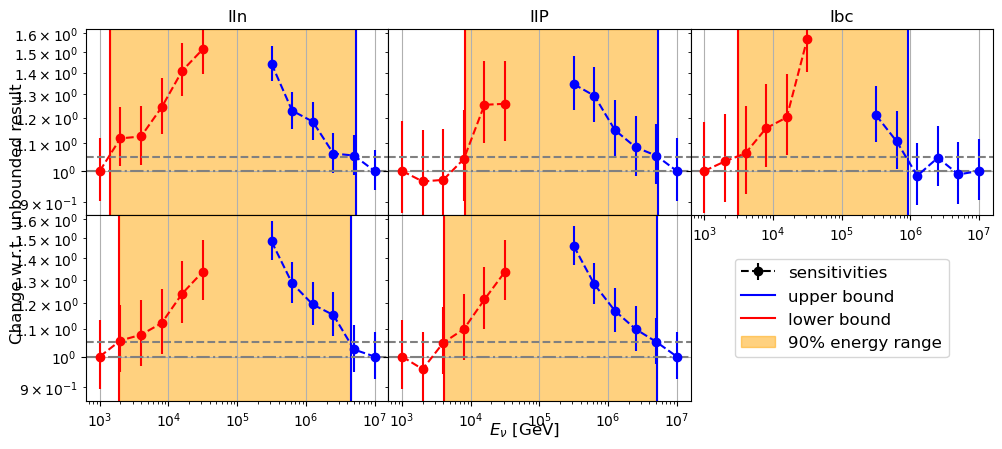

INFO:main:
 IIn 7.285 2.5
DEBUG:main:e_min_gev
DEBUG:main:type of sens is <class 'tuple'>
DEBUG:main:(3.1657912210721223e-07, array([3.27201951e-08, 4.12462490e-08]))
DEBUG:main:type of sens is <class 'tuple'>
DEBUG:main:(3.3427307076206846e-07, array([3.37076961e-08, 4.22231623e-08]))
DEBUG:main:type of sens is <class 'tuple'>
DEBUG:main:(3.087821359701113e-07, array([3.22784554e-08, 4.08107328e-08]))
DEBUG:main:type of sens is <class 'tuple'>
DEBUG:main:(3.5752146504748325e-07, array([3.49804283e-08, 4.34908454e-08]))
DEBUG:main:type of sens is <class 'tuple'>
DEBUG:main:(3.6461020231481464e-07, array([3.53636233e-08, 4.38743983e-08]))
DEBUG:main:type of sens is <class 'tuple'>
DEBUG:main:(4.262971322898679e-07, array([3.86311874e-08, 4.71825916e-08]))
DEBUG:main:e_max_gev
DEBUG:main:type of sens is <class 'tuple'>
DEBUG:main:(3.761002427950498e-07, array([2.61754985e-08, 3.04081367e-08]))
DEBUG:main:type of sens is <class 'tuple'>
DEBUG:main:(3.775803666664364e-07, array([2.62317287

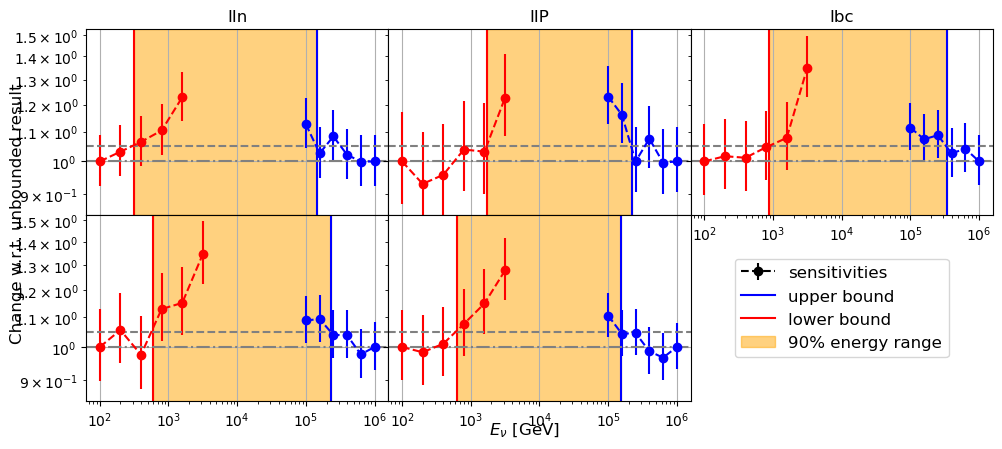

INFO:root:saving results to /Users/jannisnecker/flarestack__data/storage/analyses/ccsn/necker_2019/calculate_sensitivity_ps-v002p03/fit_weights/energy_range.pkl


In [16]:
bounds_res = dict()

for gamma in [2, 2.5]:
    
    bounds_res_pdf = dict()
    
    order = {'box': 0, 'decay': 1}
    
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(5.85*3/1.5, 3.6154988341868854*2/1.5),
                            gridspec_kw={'hspace': 0, 'wspace': 0},
                            sharex='all', sharey='all')

    for i, (pdf_type, full_res) in enumerate(energy_range_sens.items()):
        bounds_res_cat = dict()
        
        raw = f"{base_raw}/{pdf_type}/"

        with open(limit_sens(raw), 'rb') as f:
            actual_sens_dict = pickle.load(f)

        for j, (cat, cat_res) in enumerate(full_res.items()):
            for time_key, time_res in cat_res.items():

                ebound_res = time_res[gamma]
                actual_sens = actual_sens_dict[cat][time_key][gamma][0]

                logger.info(f'\n {cat} {time_key} {gamma}')
                x = list()
                y = list()
                yerr = list()
                ebk = list()

                dat = list()

                for ebound_key, erange_res in ebound_res.items():
                    logger.debug(ebound_key)

                    for ebound, sens in erange_res.items():

                        try:

                            logger.debug(f'type of sens is {type(sens)}')
                            logger.debug(sens)
                            serr = np.array((sens[0] - sens[1][0], sens[0] + sens[1][1]))
                            dat.append((
                                ebound,
                                sens[0],
                                sens[1],
                                sens[0] / actual_sens,
                                sens[1] / actual_sens,
                                ebound_key
                            ))

                        except IndexError:
                            logger.warning(f'IndexError for {cat} {time_key} {gamma} {ebound_key} {ebound}')

                toplot = pd.DataFrame(dat,
                    columns=[
                        'Energy bound [GeV]', 
                        'Flux [GeV$^{-1}$ s$^{-1}$ cm$^{-2}$]',
                        'flux_err',
                        'Flux change',
                        'flux_change_err',
                        'ebound_key'
                    ]
                )

                x = 'Energy bound [GeV]'
                y = 'Flux [GeV$^{-1}$ s$^{-1}$ cm$^{-2}$]'
                yerr = 'flux_err'
                hue = 'ebound_key'

                bounds = list()

                ax = axs[order[pdf_type]][j]
                for ihue in np.unique(toplot[hue]):

                    norm_to_ind = 0 if 'min' in ihue else -1

                    mask = toplot[hue] == ihue
                    norm_to = toplot[y][mask].iloc[norm_to_ind]
                    fine_x = np.logspace(np.log10(min(toplot[x][mask])), np.log10(max(toplot[x][mask])), 10000)
                    interp = scipy.interpolate.interp1d(toplot[x][mask], toplot[y][mask] / norm_to)
                    fine_y = interp(fine_x)
                    fine_mask = fine_y >= single_thresh
                    # find points where the threshold line is crossed
                    crossing_mask = ~(fine_mask[1:] == fine_mask[:-1])
                    liner_fine_x = (fine_x[:-1] + fine_x[1:]) / 2

                    try:
                        if 'max' in ihue:
                            bound = min(liner_fine_x[crossing_mask])
                        else:
                            bound = max(liner_fine_x[crossing_mask])

                    except ValueError:
                        bound=np.nan

                    bounds.append(bound)
                    ax.axvline(bound, label=f"{ihue}: {bound:.2e} GeV", color=colors[ihue])
                    ax.errorbar(
                        toplot[x][mask], toplot[y][mask] / norm_to, yerr=np.atleast_2d(list(toplot[yerr][mask])).T / norm_to, 
                        ls='--', marker='o', color=colors[ihue]
                    )

                ylim = ax.get_ylim()
                erange_patch = ax.fill_between(x=bounds, y1=ylim[0], y2=ylim[1],
                                               color=colors['e_range'], alpha=0.5, 
                                               label=f'{thrsh*100:.0f}% energy range')
                ax.set_ylim(ylim)
                ax.axhline(single_thresh, ls='--', color='grey')
                ax.axhline(1, ls='-.', color='grey')
                ax.set_xscale('log')
                ax.set_yscale('log')
                
                if order[pdf_type] == 0:
                    ax.set_title(f'{cat}')
                    
                ax.grid()
                ax.tick_params(axis='x', labelsize=axis_ticks_fs)
                ax.tick_params(axis='y', labelsize=axis_ticks_fs)

                bounds_res_cat[cat] = bounds
        bounds_res_pdf[pdf_type] = bounds_res_cat
    bounds_res[gamma] = bounds_res_pdf
                
    axs[-1][-1].axis('off')
    axs[0][-1].tick_params(labelbottom=True)
    
    data_patch = axs[-1][-1].errorbar([],[], yerr=[], color='k', ls='--', marker='o')
    upper_patch = axs[-1][-1].plot([], [], color=colors['e_max_gev'])
    lower_patch = axs[-1][-1].plot([], [], color=colors['e_min_gev'])
    fig.legend([data_patch, upper_patch[0], lower_patch[0], erange_patch],
               ['sensitivities', 'upper bound', 'lower bound', f'{thrsh*100:.0f}% energy range'],
               loc='center', bbox_to_anchor=axs[-1][-1].get_position(), fontsize=legend_fs)
    
    fig.text(0.5, 0.04, r"$E_{\nu}$ [GeV]", ha='center', fontsize=axis_label_fs)  # xlabel
    fig.text(0.06, 0.5, r'Change w.r.t. unbounded result',
             va='center', rotation='vertical', fontsize=axis_label_fs)  # ylabel
    
    filename = os.path.join(plot_output_dir(raw_output_dir), "unblind_ccsn", f"energyrange_gamma{gamma}.pdf")
    logger.info(f"saving under {filename}")
    fig.savefig(filename)
    
    plt.show()
    plt.close()
    
logging.info(f"saving results to {energy_range_filename}")
with open(energy_range_filename, "wb") as f:
    pickle.dump(bounds_res, f)

In [9]:
time_res

{2.5: {'elow1.0e+02_ehigh3.16e+02': (),
  'elow3.2e+02_ehigh1.00e+03': (),
  'elow1.0e+03_ehigh3.16e+03': (),
  'elow3.2e+03_ehigh1.00e+04': (),
  'elow1.0e+04_ehigh3.16e+04': (),
  'elow3.2e+04_ehigh1.00e+05': (),
  'elow1.0e+05_ehigh3.16e+05': (),
  'elow3.2e+05_ehigh1.00e+06': (),
  'elow1.0e+06_ehigh3.16e+06': (),
  'elow3.2e+06_ehigh1.00e+07': ()}}

In [ ]:
for pdf_type, full_res in energy_range_sens.items():
    raw = f"{base_raw}/{pdf_type}/"
    
    with open(limit_sens(raw), 'rb') as f:
        actual_sens_dict = pickle.load(f)
    
    for cat, cat_res in full_res.items():
        for time_key, time_res in cat_res.items():
            for gamma, ebound_res in time_res.items():
                actual_sens = actual_sens_dict[cat][time_key][gamma][0]
                
                logger.info(f'\n {cat} {time_key} {gamma}')
                x = list()
                y = list()
                yerr = list()
                ebk = list()
                
                dat = list()
                
                for ebound_key, erange_res in ebound_res.items():
                    logger.debug(ebound_key)
                    
                    for ebound, sens in erange_res.items():
                       
                        
                        try:
                        
                            logger.debug(f'type of sens is {type(sens)}')
                            logger.debug(sens)
#                             serr = np.array((sens[0] - sens[1][0], sens[0] + sens[1][1]))
                            dat.append((
                                ebound,
                                sens[0],
                                sens[1],
                                sens[0] / actual_sens,
                                sens[1] / actual_sens,
                                ebound_key
                            ))
                            
                        except IndexError as e:
                            logger.warning(f'IndexError for {cat} {time_key} {gamma} {ebound_key} {ebound}: {e}')
                            
                toplot = pd.DataFrame(dat,
                    columns=[
                        'Energy bound [GeV]', 
                        'Flux [GeV$^{-1}$ s$^{-1}$ cm$^{-2}$]',
                        'flux_err',
                        'Flux change',
                        'flux_change_err',
                        'ebound_key'
                    ]
                )
                
                x = 'Energy bound [GeV]'
                y = 'Flux [GeV$^{-1}$ s$^{-1}$ cm$^{-2}$]'
                yerr = 'flux_err'
                hue = 'ebound_key'
#                 ax = sns.lineplot(x=x, y=y, data=toplot, hue=hue)
                fig, ax = plt.subplots()
                for ihue in np.unique(toplot[hue]):
                    mask = toplot[hue] == ihue
                    ax.errorbar(toplot[x][mask], toplot[y][mask], yerr=np.atleast_2d(list(toplot[yerr][mask])).T, 
                                ls='--', color=colors[ihue])
                ax.set_xscale('log')
                ax.set_yscale('log')
                #ax.set_ylabel('Flux [GeV$^{-1}$ s$^{-1}$ cm$^{-2}$]')
                #ax.set_xlabel('Energy bound [GeV]')
                ax.set_title(f'{cat} {pdf_type} {time_key} $\gamma$={gamma:.2f}')
                
                plt.show()
                plt.close()

In [ ]:
for pdf_type, full_res in energy_range_sens.items():
    raw = f"{base_raw}/{pdf_type}/"
    
    with open(limit_sens(raw), 'rb') as f:
        actual_sens_dict = pickle.load(f)
    
    for cat, cat_res in full_res.items():
        for time_key, time_res in cat_res.items():
            for gamma, ebound_res in time_res.items():
                actual_sens = actual_sens_dict[cat][time_key][gamma][0]
                
                logger.info(f'\n {cat} {time_key} {gamma}')
                x = list()
                y = list()
                yerr = list()
                ebk = list()
                
                dat = list()
                
                for ebound_key, erange_res in ebound_res.items():
                    logger.debug(ebound_key)
                    
                    for ebound, sens in erange_res.items():
                       
                        
                        try:
                        
                            logger.debug(f'type of sens is {type(sens)}')
                            logger.debug(sens)
#                             serr = np.array((sens[0] - sens[1][0], sens[0] + sens[1][1]))
                            dat.append((
                                ebound,
                                sens[0],
                                sens[1],
                                sens[0] / actual_sens,
                                sens[1] / actual_sens,
                                ebound_key
                            ))
                            
                        except IndexError:
                            logger.warning(f'IndexError for {cat} {time_key} {gamma} {ebound_key} {ebound}')
                            
                toplot = pd.DataFrame(dat,
                    columns=[
                        'Energy bound [GeV]', 
                        'Flux [GeV$^{-1}$ s$^{-1}$ cm$^{-2}$]',
                        'flux_err',
                        'Flux change',
                        'flux_change_err',
                        'ebound_key'
                    ]
                )
                
                x = 'Energy bound [GeV]'
                y = 'Flux change'
                yerr = 'flux_change_err'
                hue = 'ebound_key'
#                 ax = sns.lineplot(x=x, y=y, data=toplot, hue=hue)

                bounds = list()

                fig, ax = plt.subplots()
                for ihue in np.unique(toplot[hue]):
                        
                    mask = toplot[hue] == ihue
                    fine_x = np.logspace(np.log10(min(toplot[x][mask])), np.log10(max(toplot[x][mask])), 10000)
                    interp = scipy.interpolate.interp1d(toplot[x][mask], toplot[y][mask])
                    fine_y = interp(fine_x)
                    fine_mask = fine_y >= single_thresh
                    
                    if 'max' in ihue:
                        bound = max(fine_x[fine_mask])
                    else:
                        bound = min(fine_x[fine_mask])
                    
                    bounds.append(bound)
                    
                    ax.axvline(bound, label=ihue, color=colors[ihue])
                    ax.errorbar(
                        toplot[x][mask], toplot[y][mask], yerr=np.atleast_2d(list(toplot[yerr][mask])).T, 
                        ls='--', marker='o', color=colors[ihue]
                    )
                    
                ylim = ax.get_ylim()
                ax.fill_between(x=bounds, y1=ylim[0], y2=ylim[1],
                               color=colors['e_range'], alpha=0.5, label=f'{thrsh*100:.0f}% energy range')
                ax.set_ylim(ylim)
                    
                ax.axhline(single_thresh, ls='--', color='grey')
                ax.axhline(1, ls='-.', color='grey')
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.set_title(f'{cat} {pdf_type} {time_key} $\gamma$={gamma:.2f}')
                
                plt.show()
                plt.close()

In [ ]:
for pdf_type, full_res in energy_range_sens.items():
    raw = f"{base_raw}/{pdf_type}/"
    
    with open(limit_sens(raw), 'rb') as f:
        actual_sens_dict = pickle.load(f)
    
    for cat, cat_res in full_res.items():
        for time_key, time_res in cat_res.items():
            for gamma, ebound_res in time_res.items():
                actual_sens = actual_sens_dict[cat][time_key][gamma][0]
                
                logger.info(f'\n {cat} {time_key} {gamma}')
                x = list()
                y = list()
                yerr = list()
                ebk = list()
                
                dat = list()
                
                for ebound_key, erange_res in ebound_res.items():
                    logger.debug(ebound_key)
                    
                    for ebound, sens in erange_res.items():
                        
                        try:
                        
                            logger.debug(f'type of sens is {type(sens)}')
                            logger.debug(sens)
                            serr = np.array((sens[0] - sens[1][0], sens[0] + sens[1][1]))
                            dat.append((
                                ebound,
                                sens[0],
                                sens[1],
                                sens[0] / actual_sens,
                                sens[1] / actual_sens,
                                ebound_key
                            ))
                            
                        except IndexError:
                            logger.warning(f'IndexError for {cat} {time_key} {gamma} {ebound_key} {ebound}')
                            
                toplot = pd.DataFrame(dat,
                    columns=[
                        'Energy bound [GeV]', 
                        'Flux [GeV$^{-1}$ s$^{-1}$ cm$^{-2}$]',
                        'flux_err',
                        'Flux change',
                        'flux_change_err',
                        'ebound_key'
                    ]
                )
                
                x = 'Energy bound [GeV]'
                y = 'Flux [GeV$^{-1}$ s$^{-1}$ cm$^{-2}$]'
                yerr = 'flux_err'
                hue = 'ebound_key'
                
                bounds = list()
                
                fig, ax = plt.subplots()
                for ihue in np.unique(toplot[hue]):
            
                    norm_to_ind = 0 if 'min' in ihue else -1
                        
                    mask = toplot[hue] == ihue
                    norm_to = toplot[y][mask].iloc[norm_to_ind]
                    fine_x = np.logspace(np.log10(min(toplot[x][mask])), np.log10(max(toplot[x][mask])), 10000)
                    interp = scipy.interpolate.interp1d(toplot[x][mask], toplot[y][mask] / norm_to)
                    fine_y = interp(fine_x)
                    fine_mask = fine_y >= single_thresh
                    
                    try:
                        if 'max' in ihue:
                            bound = max(fine_x[fine_mask])
                        else:
                            bound = min(fine_x[fine_mask])
                            
                    except ValueError:
                        bound=np.nan
                    
                    bounds.append(bound)
                    ax.axvline(bound, label=f"{ihue}: {bound:.2e} GeV", color=colors[ihue])
                    ax.errorbar(
                        toplot[x][mask], toplot[y][mask] / norm_to, yerr=np.atleast_2d(list(toplot[yerr][mask])).T / norm_to, 
                        ls='--', marker='o', color=colors[ihue]
                    )
                    
                ylim = ax.get_ylim()
                ax.fill_between(x=bounds, y1=ylim[0], y2=ylim[1],
                               color=colors['e_range'], alpha=0.5, label=f'{thrsh*100:.0f}% energy range')
                ax.set_ylim(ylim)
                ax.axhline(single_thresh, ls='--', color='grey')
                ax.axhline(1, ls='-.', color='grey')
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.legend()
                #ax.set_ylabel('Flux [GeV$^{-1}$ s$^{-1}$ cm$^{-2}$]')
                #ax.set_xlabel('Energy bound [GeV]')
                ax.set_title(f'{cat} {pdf_type} {time_key} $\gamma$={gamma:.2f}')
                
                plt.show()
                plt.close()